In [1]:
import re
import math
import string
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import jieba_fast as jieba
import plotly.express as px
import matplotlib.pyplot as plt

from io import StringIO
from opencc import OpenCC
from tqdm.auto import tqdm
from sklearn.utils import resample
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score #分类准确率
from sklearn.metrics import confusion_matrix#混淆矩陣
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer
tqdm.pandas()

In [2]:
import pandas as pd
df=pd.read_csv('comment.csv')
df = df.drop("Unnamed: 0", axis=1)
df.rename(columns={'index':'ind'},inplace=True)
df

,author,grade,comment
0,陳勁璋 JackyChen,4,在當學生時代就來過，現在帶自己的小孩來，感覺比以前更好玩，刺激的設備相對比其他的樂園多一些，...
1,CC Shen,3,很多都沒開都寫維修，連鬼屋也沒有工作人員
2,Macoto Tzeng,4,超高的摩天輪，不過遊樂器材有點少，下次來玩水比較好，玩水區看起來比較好玩。
3,Wu Ting-Ting,4,這次到劍湖山度假大飯店中的蔚藍西餐廳用餐選擇蠻多的，口味也不錯海鮮類十分新鮮好吃與王子飯店中...
4,陳榮聰,5,台灣很少一票可以玩水上跟陸上的樂園，陸上的G5跟雲霄飛車最好玩。水上的也不錯玩，而且還有人工沙灘。
...,...,...,...
5290,李重興,5,三和樂園
5291,Rick Chen,4,不錯的主題樂園
5292,妃妃,5,回憶
5293,梅長蘇,4,不錯


In [16]:
comments=[]
for i in df.comment:
    if '(由 Google 提供翻譯)' in i:
        i = i.replace('(由 Google 提供翻譯)', '').replace('(原始評論)', '')
        comments.append(i)
    else:
        comments.append(i)
len(comments)
df["comment"]=comments

In [18]:
df['comment'].fillna('',inplace=True)
df['polarity'] = df.grade.apply(lambda x: 1 if x >= 4 else -1)
df.head()

,author,grade,comment,polarity
0,陳勁璋 JackyChen,4,在當學生時代就來過，現在帶自己的小孩來，感覺比以前更好玩，刺激的設備相對比其他的樂園多一些，...,1
1,CC Shen,3,很多都沒開都寫維修，連鬼屋也沒有工作人員,-1
2,Macoto Tzeng,4,超高的摩天輪，不過遊樂器材有點少，下次來玩水比較好，玩水區看起來比較好玩。,1
3,Wu Ting-Ting,4,這次到劍湖山度假大飯店中的蔚藍西餐廳用餐選擇蠻多的，口味也不錯海鮮類十分新鮮好吃與王子飯店中...,1
4,陳榮聰,5,台灣很少一票可以玩水上跟陸上的樂園，陸上的G5跟雲霄飛車最好玩。水上的也不錯玩，而且還有人工沙灘。,1


In [19]:
train_df,valid_df = train_test_split(df,test_size=0.2,random_state=40)
train_df.polarity.value_counts()

 1    3245
-1     991
Name: polarity, dtype: int64

In [22]:
df.to_csv(path_or_buf='new_comment.csv')
df = pd.read_csv('new_comment.csv')

In [23]:
url = 'https://raw.githubusercontent.com/fxsjy/jieba/master/extra_dict/dict.txt.big'
response = requests.get(url)
with open('dict.txt.big', 'w') as f:
    f.write(response.text)
url = 'https://raw.githubusercontent.com/goto456/stopwords/master/baidu_stopwords.txt'
response = requests.get(url)
io_obj = StringIO(response.text)# StringIO模組主要用於在記憶體緩衝區中讀寫資料。
stopwords = io_obj.getvalue().split('\n')

1397

In [24]:
def _jieba_cut_words(s):
    cut_words = jieba.cut(s, cut_all=False)
    #false-精確模式(將句子最精確的切開，適合文本分析) true-把句子中所有的可以成詞的詞語都斷出来，速度非常快。
    result = []
    for word in cut_words:
        word = word.strip()
        if len(word) > 1 and word not in stopwords:
            result += [word]
    return ' '.join(result)


def _cc_transform(x):
    return cc.convert(x)


def _remove_punctuation(x):
    removed = re.sub(pattern, ' ', x)# 可以在弄熟
    return re.sub('[^\w\s]', ' ', removed)


def cleansing(data):
    removed = _remove_punctuation(data)
    converted = _cc_transform(removed)
    cut_words = _jieba_cut_words(converted)
    return cut_words


dict_path = 'dict.txt.big'

jieba.set_dictionary(dict_path)#在0.28之前的版本是不能指定主词典的路径的，有了延迟加载机制后，可以改变主词典的路径
jieba.initialize()## 手动初始化（可选）

cc = OpenCC('s2twp')  # s2twp, tw2sp 繁簡轉換利器OpenCC

pattern = "[{}]".format(string.punctuation)#如果字符是标点符号的话就将其替换为空格
pattern = pattern.replace('.', '').replace('-', '')

stopwords = [cc.convert(word) for word in stopwords]

train_df['bow'] = train_df.comment.progress_apply(cleansing)#progress_apply()运行程序的过程中，下方出现的监视过程的进度条
valid_df['bow'] = valid_df.comment.progress_apply(cleansing)

Building prefix dict from /Users/xuziyuan/Desktop/機器學習/情緒分析/dict.txt.big ...
Dumping model to file cache /var/folders/_k/r6wqm8gs1kn5wcdl_0tmm2r40000gn/T/jieba.u84aba07c1e608253c25018b51f0748d1.cache
Loading model cost 1.024 seconds.
Prefix dict has been built succesfully.
100%|██████████| 4236/4236 [00:01<00:00, 3292.72it/s]
/Users/xuziyuan/opt/anaconda3/envs/NLP_course/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 1059/1059 [00:00<00:00, 2987.22it/s]
/Users/xuziyuan/opt/anaconda3/envs/NLP_course/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [25]:
train_df.describe()

,grade,polarity
count,4236.000000,4236.000000
mean,4.070585,0.532106
std,1.093924,0.846778
min,1.000000,-1.000000
25%,4.000000,1.000000
50%,4.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [26]:
def display_ngram(data,ngram=2,num=20,height=None):
    vectorizer = CountVectorizer(ngram_range=(ngram,ngram))
    bow = vectorizer.fit_transform(data)

    total_conbines = np.array(bow.sum(axis=0)).squeeze()
    words_freq = map(lambda x:[x[0],total_conbines[x[1]]],vectorizer.vocabulary_.items())
    words_freq = pd.DataFrame(words_freq,columns=['ngram_words','cnt'])
    words_freq.sort_values(by='cnt',ascending=False,inplace=True)

    if height is None:
        height = 200 + (num * 20)
    fig = px.bar(
        words_freq[:num], x="cnt", y="ngram_words", title=f'{ngram}-grams', 
        orientation='h', height=height, color='ngram_words')
    fig.show()


display_ngram(train_df[train_df.polarity == 1].bow, ngram=3, num=30)

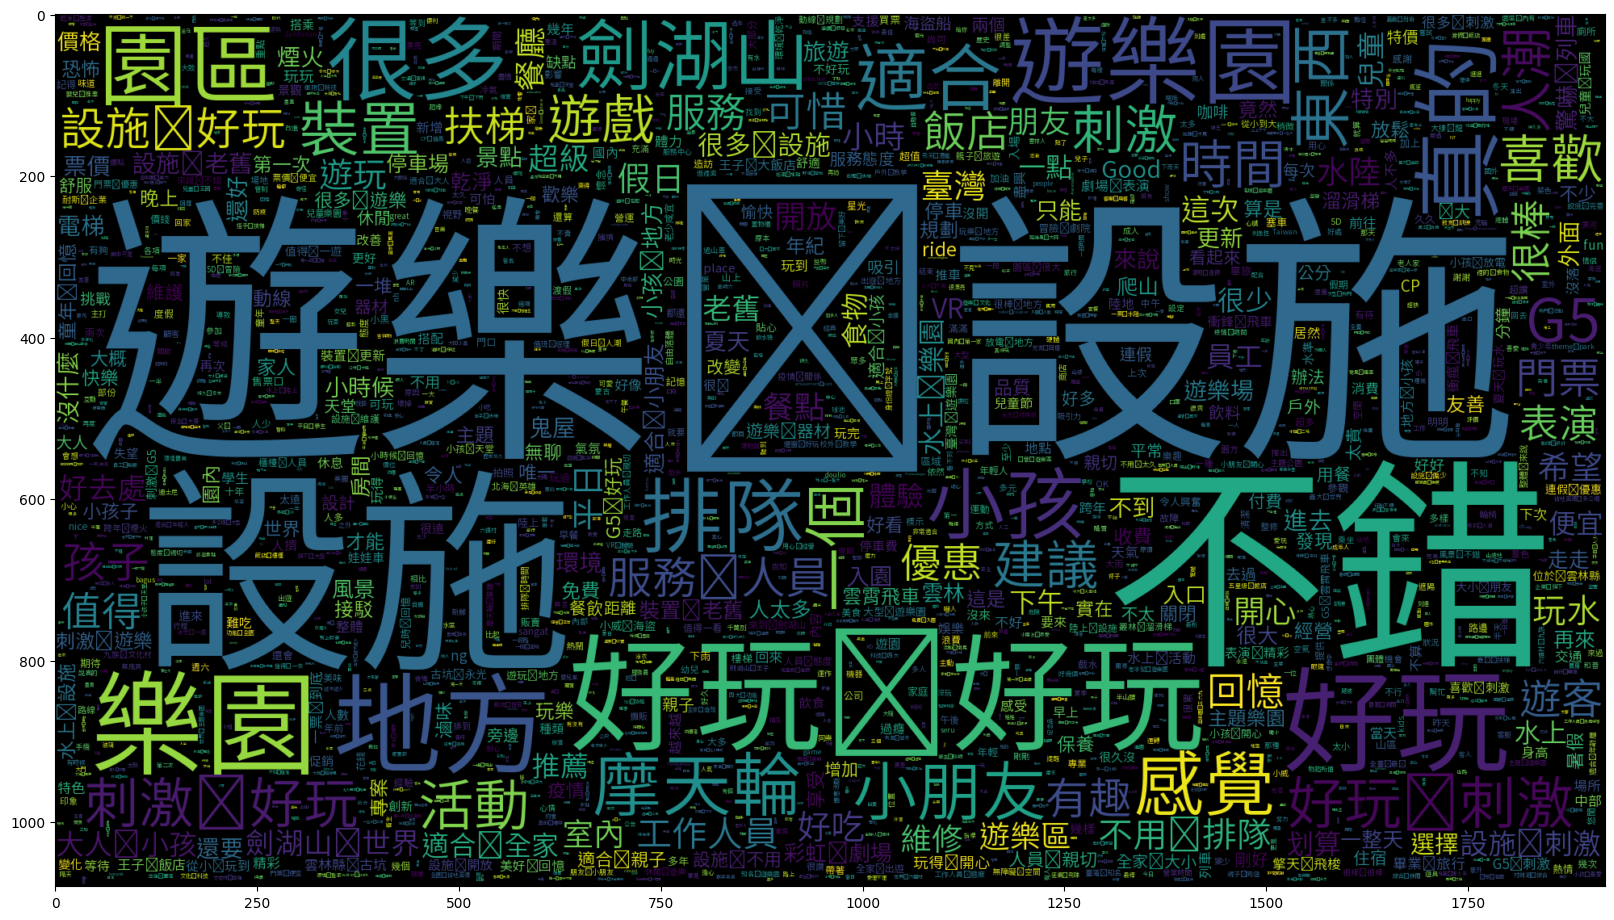

In [27]:
url = 'https://raw.githubusercontent.com/g0v/moedict.tw/master/SourceHanSansTW-Normal.ttf'

response = requests.get(url)
with open('SourceHanSansTW-Normal.ttf', 'wb') as f:
    f.write(response.content)

plt.figure(figsize = (20,20))

# 設置英文停止詞 stopwords=STOPWORDS
wc = WordCloud(
    stopwords=STOPWORDS, font_path='SourceHanSansTW-Normal.ttf', 
    max_words=2560, width=1920 ,  height=1080)
wc = wc.generate(" ".join(train_df.bow))
plt.imshow(wc, interpolation='bilinear')
plt.show()

wc.to_file('wordcloud.png')